# Convolutional Neural Networks

Sometimes looking at the learned coefficients of a neural network can provide insight into the learning behavior. For example if weights look unstructured, maybe some were not used at all, or if very large coefficients exist, maybe regularization was too low or the learning rate too high.

This example shows how to plot some of the first layer weights in a MLPClassifier trained on the MNIST dataset.

The input data consists of 28x28 pixel handwritten digits, leading to 784 features in the dataset. Therefore the first layer weight matrix have the shape (784, hidden_layer_sizes[0]). We can therefore visualize a single column of the weight matrix as a 28x28 pixel image.

To make the example run faster, we use very few hidden units, and train only for a very short time. Training longer would result in weights with a much smoother spatial appearance.

In [3]:
from ml.neural_network.activations import relu, softmax
from ml.neural_network.layers import Conv2D, MaxPool2D, Flatten, FullyConnected
from ml.neural_network.losses import sparse_categorical_cross_entropy
from ml.neural_network.neural_network import NeuralNetworkClassifier
from optimization.unconstrained.stochastic.adam import Adam
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml
from utils import plot_model_accuracy, plot_model_loss

In [10]:
X, y = fetch_openml('mnist_784', return_X_y=True)
# normalizing the RGB codes by dividing it to the max RGB value
X /= 255.

# rescale the data, use the traditional train/test split
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

In [11]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=0.1)

mlp.fit(X_train, y_train)
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

Iteration 1, loss = 0.32009978
Iteration 2, loss = 0.15347534
Iteration 3, loss = 0.11544755
Iteration 4, loss = 0.09279764
Iteration 5, loss = 0.07889367
Iteration 6, loss = 0.07170497
Iteration 7, loss = 0.06282111
Iteration 8, loss = 0.05530788
Iteration 9, loss = 0.04960484
Iteration 10, loss = 0.04645355


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Training set score: 0.986800
Test set score: 0.970000


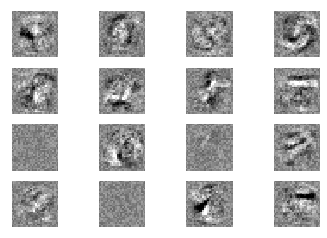

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4)
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

In [7]:
# reshape data for convolutionals layers
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

cnn = NeuralNetworkClassifier(
    (Conv2D(in_channels=1, out_channels=6, kernel_size=(5, 5), strides=(1, 1),
            padding='same', channels_last=True, activation=relu),  # => [n,28,28,6]
     MaxPool2D(pool_size=(2, 2), strides=(2, 2)),  # => [n,14,14,6]
     Conv2D(in_channels=6, out_channels=16, kernel_size=(5, 5), strides=(1, 1),
            padding='same', channels_last=True, activation=relu),  # => [n,14,14,16]
     MaxPool2D(pool_size=(2, 2), strides=(2, 2)),  # => [n,7,7,16]
     Flatten(),  # => [n,7*7*16]
     FullyConnected(n_in=7 * 7 * 16, n_out=10, activation=softmax)),
    loss=sparse_categorical_cross_entropy, optimizer=Adam, learning_rate=0.002,
    max_iter=300, batch_size=64, verbose=10)
cnn.fit(X_train, y_train)
plot_model_loss(cnn.loss_history)
plot_model_accuracy(cnn.accuracy_history)
print(classification_report(y_test, cnn.predict(X_test)))

iter	f(x)		||g(x)||

TypeError: exceptions must derive from BaseException